In [1]:
import os
import shutil
import pandas as pd
import random
import numpy as np

import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201

import cv2

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv("/kaggle/input/plant-pathology-2020-fgvc7/train.csv")
train_df['img_name'] = train_df['image_id'] + ".jpg"
train_df.head()

,image_id,healthy,multiple_diseases,rust,scab,img_name
0,Train_0,0,0,0,1,Train_0.jpg
1,Train_1,0,1,0,0,Train_1.jpg
2,Train_2,1,0,0,0,Train_2.jpg
3,Train_3,0,0,1,0,Train_3.jpg
4,Train_4,1,0,0,0,Train_4.jpg


In [3]:
target_multi_cols = ['healthy', 'multiple_diseases', 'rust', 'scab']

print("Multi Classification Targets")
print(train_df[target_multi_cols].sum())

Multi Classification Targets
healthy              516
multiple_diseases     91
rust                 622
scab                 592
dtype: int64


In [4]:
def balance_set(df, x_cols, y_cols):
    ros = RandomOverSampler(random_state=42)

    x_multi, y_multi = ros.fit_resample(df[x_cols], df[y_cols].values)
    data = pd.concat([x_multi, pd.DataFrame(y_multi, columns= y_cols)], axis=1)
    return data

train_multi = balance_set(train_df, 
                          x_cols = ["image_id", "img_name"],
                          y_cols = target_multi_cols)


labels = train_multi[target_multi_cols]
label_names = labels[labels==1].stack().reset_index()['level_1']
label_names.index = train_multi.index
train_multi['label_names'] = label_names

print("Multi Classification Labels")
print(train_multi[target_multi_cols].sum())

Multi Classification Labels
healthy              622
multiple_diseases    622
rust                 622
scab                 622
dtype: int64


In [5]:
# a look at the multi class dataframe
train_multi.head()

,image_id,img_name,healthy,multiple_diseases,rust,scab,label_names
0,Train_0,Train_0.jpg,0,0,0,1,scab
1,Train_1,Train_1.jpg,0,1,0,0,multiple_diseases
2,Train_2,Train_2.jpg,1,0,0,0,healthy
3,Train_3,Train_3.jpg,0,0,1,0,rust
4,Train_4,Train_4.jpg,1,0,0,0,healthy


In [6]:
def blur_preprocessing(img):
    return cv2.blur(img, (5, 5))

tf.random.set_seed(99)

## Initalize Image Data Generator with Augmentation
img_data_generator = ImageDataGenerator(rescale=1/255, 
                                        validation_split=0.2,
                                        rotation_range = 180,
                                        horizontal_flip = True,
                                        vertical_flip = True,
                                        preprocessing_function=blur_preprocessing
                                       )


## Recreate datasets from dataframe
train_data_multi = img_data_generator.flow_from_dataframe(dataframe=train_multi,
                                                    directory="/kaggle/input/plant-pathology-2020-fgvc7/images/",
                                                    x_col="img_name",
                                                    y_col= "label_names",
                                                    target_size=(256, 256),
                                                    class_mode='categorical',
                                                    batch_size=32,
                                                    subset='training',
                                                    shuffle=True,
                                                    seed=42)

val_data_multi = img_data_generator.flow_from_dataframe(dataframe=train_multi,
                                                    directory="/kaggle/input/plant-pathology-2020-fgvc7/images/",
                                                    x_col="img_name",
                                                    y_col="label_names",
                                                    target_size=(256, 256),
                                                    class_mode='categorical',
                                                    batch_size=32,
                                                    subset='validation',
                                                    shuffle=True,
                                                    seed=42)

Found 1991 validated image filenames belonging to 4 classes.
Found 497 validated image filenames belonging to 4 classes.


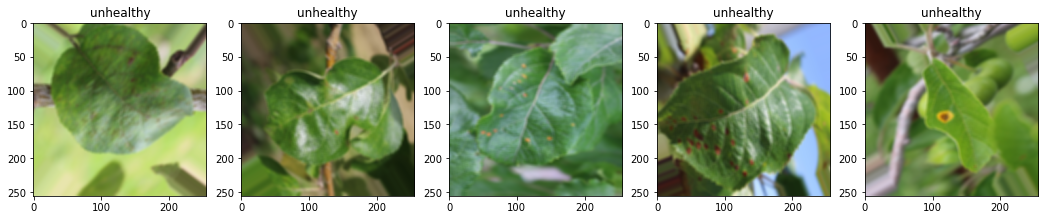

In [7]:
def show_imgs(df, num):
    fig, ax = plt.subplots(1,num, figsize=(18,9))
    for x, y in df:
        for img in range(num):
            ax[img].imshow(x[img])
            if y[img][0]:
                title="healthy"
            else:
                title='unhealthy'
            ax[img].set_title(title)
        break
show_imgs(train_data_multi, 5)

In [8]:
# learning rate decay
learning_rate_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0003, 
                                                                         decay_steps=2, 
                                                                         decay_rate=0.97, 
                                                                         staircase=False)

In [9]:
try:
    os.mkdir("../tmp")
except:
    print("Directory /tmp already exists")

checkpoint = tf.keras.callbacks.ModelCheckpoint("../tmp/multi_class_weights_1", 
                                                monitor='val_loss', 
                                                verbose=1, 
                                                save_best_only=False,
                                                save_weights_only=True, 
                                                period=1)




In [10]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs=None):
        self.patience = 3
        self.best = 0
        self.wait = 0
    
    def on_epoch_end(self, epoch, logs=None):
        if np.greater(logs["val_accuracy"], self.best):
            self.wait = 0
            self.best = logs["val_accuracy"]
        else:
            self.wait +=1
            if self.wait >= self.patience:
                print(f"Stopping Training. Validation accuracy hasn't improved >= {self.patience} times")
                self.model.stop_training=True

In [11]:
def dense_net_model(trainable_weights=False, weights_path=None):
    
    tf.keras.backend.clear_session()
    
    dense_net = DenseNet201(input_shape=(256, 256, 3), weights="imagenet", include_top=False)
    
    for layer in dense_net.layers:
        layer.trainable=trainable_weights
    
    model = tf.keras.models.Sequential([dense_net,
                                        tf.keras.layers.GlobalAveragePooling2D(),
                                        tf.keras.layers.Dense(128, activation='relu'),
                                        tf.keras.layers.Dropout(0.3),
                                        tf.keras.layers.Dense(4, activation='softmax')
                                ])
    
    if weights_path:
        model.load_weights(weights_path)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_scheduler)
    
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    
    return model

dense_net_transfer = dense_net_model(trainable_weights=True)

dense_net_transfer_history = dense_net_transfer.fit(train_data_multi, validation_data=val_data_multi, epochs=25, steps_per_epoch=32, callbacks=[checkpoint, EarlyStoppingCallback()])

74842112/74836368 [==============================] - 1s 0us/step
Epoch 1/25
32/32 [==============================] - ETA: 0s - loss: 0.7690 - accuracy: 0.7007
Epoch 00001: saving model to ../tmp/multi_class_weights_1
32/32 [==============================] - 83s 3s/step - loss: 0.7690 - accuracy: 0.7007 - val_loss: 1.1759 - val_accuracy: 0.5634
Epoch 2/25
32/32 [==============================] - ETA: 0s - loss: 0.3262 - accuracy: 0.8919
Epoch 00002: saving model to ../tmp/multi_class_weights_1
32/32 [==============================] - 73s 2s/step - loss: 0.3262 - accuracy: 0.8919 - val_loss: 0.7553 - val_accuracy: 0.6982
Epoch 3/25
32/32 [==============================] - ETA: 0s - loss: 0.2024 - accuracy: 0.9385
Epoch 00003: saving model to ../tmp/multi_class_weights_1
32/32 [==============================] - 74s 2s/step - loss: 0.2024 - accuracy: 0.9385 - val_loss: 0.5667 - val_accuracy: 0.7726
Epoch 4/25
32/32 [==============================] - ETA: 0s - loss: 0.1480 - accuracy: 0.953

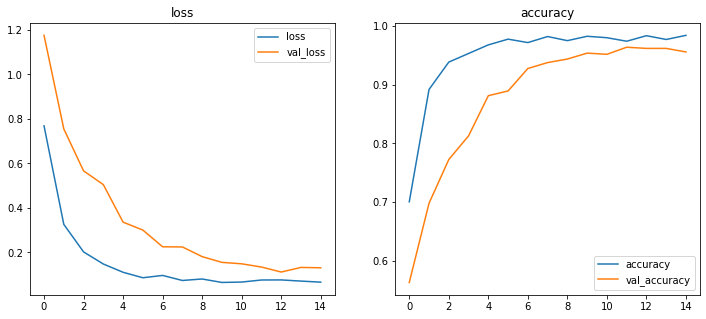

In [12]:
#plot loss and accuracy helper function
def plot_loss_accuracy(history):
    fig, axs = plt.subplots(1,2, figsize=(12, 5))

    hist = history.history

    for ax, metric in zip(axs, ["loss", "accuracy"]):
        ax.plot(hist[metric])
        ax.plot(hist["val_"+metric])
        ax.legend([metric, "val_" + metric])
        ax.set_title(metric)

plot_loss_accuracy(dense_net_transfer_history)

In [13]:
test_df = pd.read_csv("/kaggle/input/plant-pathology-2020-fgvc7/test.csv")
test_df['img_name'] = test_df['image_id'] + ".jpg"

test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = test_datagen.flow_from_dataframe(dataframe=test_df,
                                                  directory="/kaggle/input/plant-pathology-2020-fgvc7/images/",
                                                  x_col="img_name",
                                                  y_col=None,
                                                  target_size=(256, 256),
                                                  class_mode=None,
                                                  batch_size=3,
                                                  shuffle=False,
                                                  seed=42)

test_generator.reset()

Found 1821 validated image filenames.


In [14]:

preds = dense_net_transfer.predict_generator(test_generator, verbose=1, steps=607)

preds_df = pd.DataFrame(preds, columns=["healthy", "multiple_diseases", "rust", "scab"])

submission = pd.concat([test_df.image_id, preds_df], axis=1)

submission.head()

607/607 [==============================] - 76s 125ms/step


,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.001006,0.014765,0.984148,0.000081
1,Test_1,0.002153,0.014648,0.982935,0.000264
2,Test_2,0.014887,0.028593,0.011877,0.944643
3,Test_3,0.999493,0.000023,0.000424,0.000060
4,Test_4,0.002109,0.057598,0.939233,0.001060


In [ ]:
submission.to_csv("submission_DenseNet.csv", index=False)